In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 20
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [4]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 15
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [5]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

In [6]:
import pycbc.catalog

c = pycbc.catalog.Catalog(source='gwtc-2')

# Names of mergers in the catalog
print(c.names)

# Approximate GPS time of the mergers
print([c[m].time for m in c])


dict_keys(['GW190930_133541-v1', 'GW190929_012149-v1', 'GW190924_021846-v1', 'GW190915_235702-v1', 'GW190910_112807-v1', 'GW190909_114149-v1', 'GW190828_065509-v1', 'GW190828_063405-v1', 'GW190814-v2', 'GW190803_022701-v1', 'GW190731_140936-v1', 'GW190728_064510-v1', 'GW190727_060333-v1', 'GW190720_000836-v1', 'GW190719_215514-v1', 'GW190708_232457-v1', 'GW190707_093326-v1', 'GW190706_222641-v1', 'GW190701_203306-v1', 'GW190630_185205-v1', 'GW190620_030421-v1', 'GW190602_175927-v1', 'GW190527_092055-v1', 'GW190521_074359-v1', 'GW190521-v3', 'GW190519_153544-v1', 'GW190517_055101-v1', 'GW190514_065416-v1', 'GW190513_205428-v1', 'GW190512_180714-v1', 'GW190503_185404-v1', 'GW190426_152155-v1', 'GW190425-v2', 'GW190424_180648-v1', 'GW190421_213856-v1', 'GW190413_134308-v1', 'GW190413_052954-v1', 'GW190412-v3', 'GW190408_181802-v1'])
[1253885759.2, 1253755327.5, 1253326744.8, 1252627040.7, 1252150105.3, 1252064527.7, 1251010527.9, 1251009263.8, 1249852257.0, 1248834439.9, 1248617394.6, 124

# GW190521

In [7]:
import pandas as pd
import numpy as np

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190521_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [8]:
np.where((input_data['time,'].values > 1242442967.447) & (input_data['time,'].values < 1242442967.448))[0]


array([4554])

In [9]:
4554 -(1024*0.8)

3734.8

In [10]:
4554 + (1024*0.2)

4758.8

In [11]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190521.hdf', 'r')
strain = f1['GW190521-v3']['l1_strain'][()]


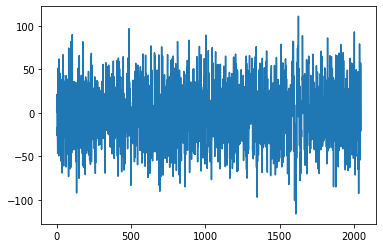

In [12]:
plt.plot(strain)

In [13]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [14]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2063, 15, 1)


In [14]:
class TimeDistributedMultiHeadAttention(tf.keras.layers.Layer):
        def __init__(self, num_heads, key_dim, **kwargs):
            super().__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        def call(self, inputs):
            # Use tf.shape for dynamic shape and inputs.shape for static shape
            shape = tf.shape(inputs)
            static_shape = inputs.shape
            batch_size, num_subsequences, subsequence_length = shape[0], static_shape[1], static_shape[2]
            features = static_shape[3]

            reshaped_inputs = tf.reshape(inputs, [-1, subsequence_length, features])

            # Apply multi-head attention to each subsequence individually
            attention_output = self.multi_head_attention(reshaped_inputs, reshaped_inputs)

            # Reshape the output back to the original input shape
            output_shape = [-1, num_subsequences, subsequence_length, features]
            return tf.reshape(attention_output, output_shape)

        def compute_output_shape(self, input_shape):
            return input_shape
        
        def get_config(self):
            config = super().get_config()
            config.update({
                'num_heads': self.num_heads,
                'key_dim': self.key_dim
            })
            return config


In [16]:
class NegativeLogLikelihood:
    def __call__(self, y, rv_y):
        return -rv_y.log_prob(y)

# Instantiate the loss function
negloglik = NegativeLogLikelihood()


In [17]:
import tensorflow_probability as tfp

#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_15_timesteps_uncertainty.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})

# load model
#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 2063, 15, 1)      4         
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 2063, 15, 64)     256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2063, 15, 32)     6176      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2063, 15, 32)     3104      
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 2063, 15, 32)      0

In [18]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


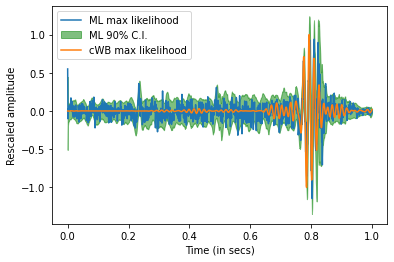

In [19]:
distribution = model(X_test_noisy)
    
# Extract mean and standard deviation from the distribution
mean_preds = distribution.mean()
std_preds = distribution.stddev()
 
mean_preds = mean_preds.numpy().squeeze()
std_preds = std_preds.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound = mean_preds - 2 * std_preds
upper_bound = mean_preds + 2 * std_preds

time = np.linspace(0.0, 1.0, 1024)

plt.plot(time, decoded_signals[0][::2][0:1024], label ='ML max likelihood')

cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][0:1024][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.fill_between(time, lower_bound[::2][0:1024], upper_bound[::2][0:1024], color='green', alpha=0.5, label='ML 90% C.I.')
plt.plot(time, cwb_reconst[0], label ='cWB max likelihood')
plt.xlabel('Time (in secs)')
plt.ylabel('Rescaled amplitude')
plt.legend()

#plt.savefig('IMBH_test/O3_real_events/GW190521_uncertainty.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


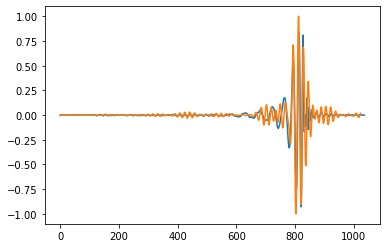

In [174]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [20]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [21]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190521_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


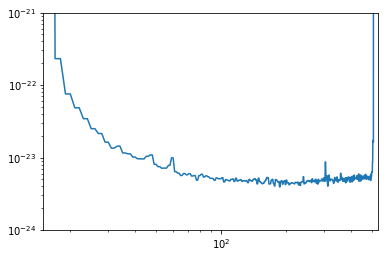

In [22]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [23]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, lower_bound, upper_bound, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightblue', label='cWB-LALInference 90% C.I.', alpha=0.5)
    signal_axes.fill_between(time,lower_bound,upper_bound, color='lightpink', label='ML 90% C.I.', alpha=0.5)
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend(loc='lower left')
    
#    plt.savefig('IMBH_test/O3_real_events/GW190521_reconstruction_CI_dilated_CNN_25_timesteps_L1_cWB_comparison_uncertainty.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


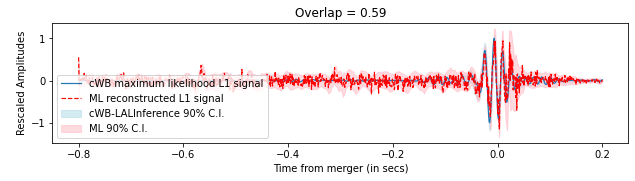

In [24]:
#plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(cwb_reconst).astype(np.float64), new_upper, new_lower, psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(cwb_reconst).astype(np.float64), new_upper, new_lower, lower_bound[::2][0:1024], upper_bound[::2][0:1024], psd)


# SNR computation

In [80]:
import numpy as np
from pycbc.filter import sigma
from pycbc.types import TimeSeries, FrequencySeries

# Assuming 'psd' is your power spectral density data
# and 'cwb_reconst' and 'decoded_signals' are your reconstructed signals

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190521_rec_signal_time_L1.dat",header=0,delimiter=" ")
cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]

from pycbc.psd import inverse_spectrum_truncation, interpolate

# Length of corresponding time series and frequency series
time_buffer = 1
tlen = int(1024.0 * time_buffer)
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer

# Create FrequencySeries for PSD
psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

psd = inverse_spectrum_truncation(psd_fs,
                   max_filter_len=4,
                   low_frequency_cutoff=20.0,
                   trunc_method='hann')


# Create TimeSeries for reconstructed signals
cwb_reconst_ts = TimeSeries(np.array(cwb_reconst).squeeze(), delta_t=1.0/1024)
ml_reconst_ts = TimeSeries(decoded_signals[0][::2][0:1024].squeeze().astype(np.float64), delta_t=1.0/1024)

# Convert TimeSeries to FrequencySeries
cwb_reconst_fs = cwb_reconst_ts.to_frequencyseries()
ml_reconst_fs = ml_reconst_ts.to_frequencyseries()

# Unwhiten the signals by multiplying with the square root of PSD
unwhitened_cwb_reconst = (cwb_reconst_fs * (psd**0.5)).to_timeseries()
unwhitened_ml_reconst = (ml_reconst_fs * (psd**0.5)).to_timeseries()

# Optionally, calculate SNR if needed
snr_cwb = sigma(htilde=cwb_reconst_ts, psd=None, low_frequency_cutoff=20.0)
snr_ml = sigma(htilde=ml_reconst_ts, psd=None, low_frequency_cutoff=20.0)

# OR
snr_cwb_1 = sigma(htilde=unwhitened_cwb_reconst, psd=psd, low_frequency_cutoff=20.0)
snr_ml_1 = sigma(htilde=unwhitened_ml_reconst, psd=psd, low_frequency_cutoff=20.0)


In [183]:
input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190521_rec_signal_time_L1.dat",header=0,delimiter=" ")
cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]


In [184]:
import numpy as np
from scipy.fft import fft, ifft

psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

psd = inverse_spectrum_truncation(psd_fs,
                   max_filter_len=4,
                   low_frequency_cutoff=20.0,
                   trunc_method='hann')

h_fft = fft(cwb_reconst)
template_fft = fft(cwb_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(cwb_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr = np.max(snr_time)


In [185]:
np.sqrt(optimal_snr)

12.078983190497215

In [186]:
import numpy as np
from scipy.fft import fft, ifft

ml_reconst = 3*decoded_signals[0][::2][0:1024].squeeze()

h_fft = fft(ml_reconst)
template_fft = fft(ml_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(ml_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr = np.max(snr_time)


In [187]:
np.sqrt(optimal_snr)

11.268097

In [129]:
len(decoded_signals[0][::2][0:1024])

1024

In [126]:
decoded_signals[0][::2][0:1024].squeeze()

array([-0.00280574,  0.00129709,  0.00067752, ...,  0.00034164,
        0.00101381,  0.00191071], dtype=float32)

In [7]:
import numpy as np
from scipy.fft import fft, ifft

ml_reconst = np.zeros(1024)

h_fft = fft(ml_reconst)
template_fft = fft(ml_reconst)
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr = np.max(snr_time)


In [9]:
np.sqrt(optimal_snr)

0.0

# Plot PE maximum likelihood waveform

In [22]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190521_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [23]:
np.where((time > 1242442967.447) & (time < 1242442967.448))[0]


array([4554])

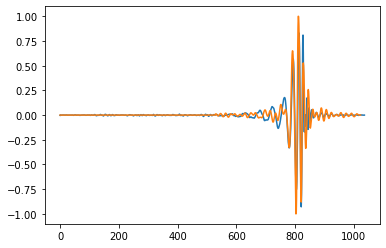

In [24]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[3735:4759][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [25]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3735:4759]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

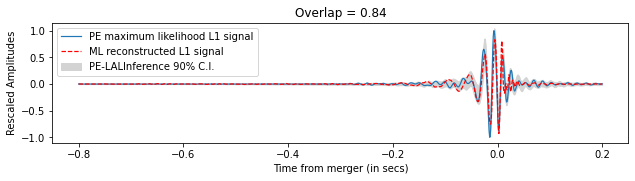

In [28]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


In [57]:
import numpy as np
from pycbc.filter import sigma
from pycbc.types import TimeSeries, FrequencySeries

# Assuming 'psd' is your power spectral density data
# and 'cwb_reconst' and 'decoded_signals' are your reconstructed signals

# Length of corresponding time series and frequency series
time_buffer = 1
tlen = int(1024.0 * time_buffer)
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer

# Create FrequencySeries for PSD
psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

# Create TimeSeries for reconstructed signals
pe_reconst_ts = TimeSeries(np.array(pe_reconst).squeeze(), delta_t=1.0/1024)
ml_reconst_ts = TimeSeries(decoded_signals[0][::2][0:1024].squeeze().astype(np.float64), delta_t=1.0/1024)

# Convert TimeSeries to FrequencySeries
pe_reconst_fs = pe_reconst_ts.to_frequencyseries()
ml_reconst_fs = ml_reconst_ts.to_frequencyseries()

# Unwhiten the signals by multiplying with the square root of PSD
unwhitened_pe_reconst = (pe_reconst_fs * psd_fs).to_timeseries()
unwhitened_ml_reconst = (ml_reconst_fs * psd_fs).to_timeseries()

# Optionally, calculate SNR if needed
snr_pe = sigma(htilde=unwhitened_pe_reconst, psd=psd_fs, low_frequency_cutoff=20.0)
snr_ml = sigma(htilde=unwhitened_ml_reconst, psd=psd_fs, low_frequency_cutoff=20.0)


In [55]:
snr_pe

61.089398072151695

In [56]:
snr_ml

31.39917653861595

# BayesWave comparison

In [6]:
import pandas as pd
import numpy as np

input_data_BW=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190521_BayesWave_L1.txt",header=0,delimiter=" ")


In [7]:
trig_time = 1242442967.447265625
seg_length = 8.0

times = input_data_BW['time'].values + (trig_time - seg_length/2)

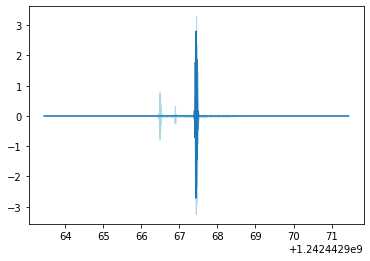

In [8]:
plt.plot(times, input_data_BW['median'].values)
plt.fill_between(times, input_data_BW['90%_lower'].values, input_data_BW['90%_upper'].values, color='lightblue')

In [9]:
times[np.argmax(input_data_BW['median'].values)]


1242442967.4404256

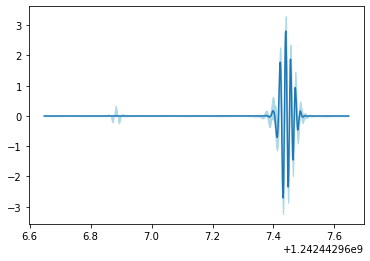

In [21]:
trigger_index = np.where(times == trig_time)[0][0]

left = int(np.round(trigger_index - (0.8*1024)))

right = int(np.round(trigger_index + (0.2*1024)))

plt.plot(times[left:right], input_data_BW['median'].values[left:right])
plt.fill_between(times[left:right], input_data_BW['90%_lower'].values[left:right], input_data_BW['90%_upper'].values[left:right], color='lightblue')


# GW191109_010717

In [210]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW191109_010717_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [211]:
np.where((input_data['time,'].values > 1257296855.221) & (input_data['time,'].values < 1257296855.223))[0]


array([7395, 7396])

In [212]:
7395 -(1024*0.8)

6575.8

In [213]:
7395 + (1024*0.2)

7599.8

In [214]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW191109_010717.hdf', 'r')
strain = f1['GW191109_010717-v1']['l1_strain'][()]


In [215]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [216]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [217]:
#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [218]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


In [222]:
import numpy as np
from pycbc.filter import sigma
from pycbc.types import TimeSeries, FrequencySeries

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW191109_010717_rec_signal_time_L1.dat",header=0,delimiter=" ")
cwb_reconst = input_data['amp_cwb_rec,'].values[6576:7600][None,:]

# Assuming 'psd' is your power spectral density data
# and 'cwb_reconst' and 'decoded_signals' are your reconstructed signals

# Length of corresponding time series and frequency series
time_buffer = 1
tlen = int(1024.0 * time_buffer)
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer

# Create FrequencySeries for PSD
psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

# Create TimeSeries for reconstructed signals
cwb_reconst_ts = TimeSeries(np.array(cwb_reconst).squeeze(), delta_t=1.0/1024)

# Convert TimeSeries to FrequencySeries
cwb_reconst_fs = cwb_reconst_ts.to_frequencyseries()

# Unwhiten the signals by multiplying with the square root of PSD
unwhitened_cwb_reconst = (cwb_reconst_fs * (psd_fs)**0.5).to_timeseries()

# Optionally, calculate SNR if needed
sigma(htilde=unwhitened_cwb_reconst, psd=psd_fs, low_frequency_cutoff=20.0)


/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/pycbc/scheme.py:191: RuntimeWarning: invalid value encountered in divide
  return _import_cache[mgr.state][func](*args, **kwds)


nan

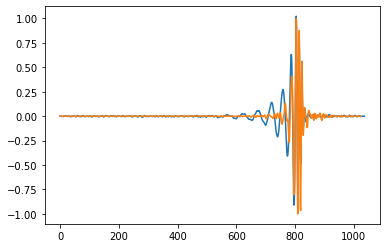

In [219]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6576:7600][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [220]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6576:7600]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6576:7600]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [221]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW191109_010717_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


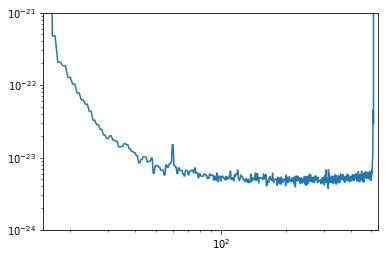

In [222]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [75]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW191109_010717_reconstruction_CI_dilated_CNN_25_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


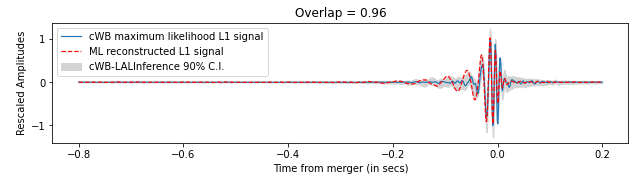

In [76]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


In [233]:
# Create FrequencySeries for PSD
psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

psd = inverse_spectrum_truncation(psd_fs,
                   max_filter_len=4,
                   low_frequency_cutoff=20.0,
                   trunc_method='hann')


input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW191109_010717_rec_signal_time_L1.dat",header=0,delimiter=" ")
cwb_reconst = input_data['amp_cwb_rec,'].values[6576:7600][None,:]

import numpy as np
from scipy.fft import fft, ifft

h_fft = fft(cwb_reconst)
template_fft = fft(cwb_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(cwb_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_cwb = np.max(snr_time)


In [234]:
np.sqrt(optimal_snr_cwb)

12.201200809895333

In [235]:
import numpy as np
from scipy.fft import fft, ifft


ml_reconst = round(cwb_reconst.max())*decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)

#ml_reconst = decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)


h_fft = fft(ml_reconst)
template_fft = fft(ml_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(ml_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_ml = np.max(snr_time)


In [236]:
np.sqrt(optimal_snr_ml)

12.09087989027637

In [237]:
np.sqrt(optimal_snr_ml)/np.sqrt(optimal_snr_cwb)

0.9909581916290163

In [227]:
import numpy as np
from pycbc.filter import sigma
from pycbc.types import TimeSeries, FrequencySeries

# Assuming 'psd' is your power spectral density data
# and 'cwb_reconst' and 'decoded_signals' are your reconstructed signals

#input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190521_rec_signal_time_L1.dat",header=0,delimiter=" ")
#cwb_reconst = input_data['amp_cwb_rec,'].values[3735:4759][None,:]

from pycbc.psd import inverse_spectrum_truncation, interpolate

# Length of corresponding time series and frequency series
time_buffer = 1
tlen = int(1024.0 * time_buffer)
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer

# Create FrequencySeries for PSD
psd_fs = FrequencySeries(psd, delta_f=delta_f)
psd_fs.resize(flen)

psd = inverse_spectrum_truncation(psd_fs,
                   max_filter_len=4,
                   low_frequency_cutoff=20.0,
                   trunc_method='hann')


# Create TimeSeries for reconstructed signals
cwb_reconst_ts = TimeSeries(np.array(cwb_reconst).squeeze(), delta_t=1.0/1024)
ml_reconst_ts = TimeSeries(decoded_signals[0][::2][0:1024].squeeze().astype(np.float64), delta_t=1.0/1024)

# Convert TimeSeries to FrequencySeries
cwb_reconst_fs = cwb_reconst_ts.to_frequencyseries()
ml_reconst_fs = ml_reconst_ts.to_frequencyseries()

# Unwhiten the signals by multiplying with the square root of PSD
unwhitened_cwb_reconst = (cwb_reconst_fs * (psd**0.5)).to_timeseries()
unwhitened_ml_reconst = (ml_reconst_fs * (psd**0.5)).to_timeseries()

# Optionally, calculate SNR if needed
snr_cwb = sigma(htilde=unwhitened_cwb_reconst, psd=psd, low_frequency_cutoff=20.0)
snr_ml = sigma(htilde=unwhitened_ml_reconst, psd=psd, low_frequency_cutoff=20.0)


In [228]:
snr_cwb

0.16848048498219384

In [229]:
snr_ml

0.17798082046201644

In [230]:
snr_cwb/snr_ml

0.9466215772285975

# PE comparison

In [77]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW191109_010717_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [78]:
np.where((time > 1257296855.221) & (time < 1257296855.223))[0]


array([7395, 7396])

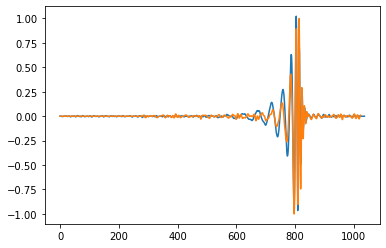

In [79]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6576:7600][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [80]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6576:7600]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6576:7600]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [81]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW191109_010717_reconstruction_CI_dilated_CNN_25_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


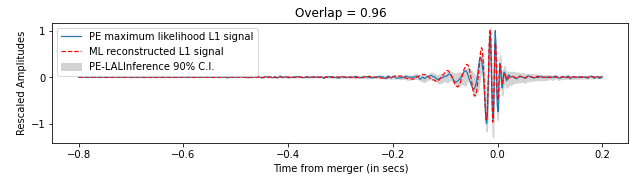

In [82]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW190602_175927

In [271]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190602_175927_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [272]:
np.where((input_data['time,'].values > 1243533585.084) & (input_data['time,'].values < 1243533585.086))[0]


array([4183, 4184])

In [273]:
4183 -(1024*0.8)

3363.8

In [274]:
4183 + (1024*0.2)

4387.8

In [275]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190602_175927.hdf', 'r')
strain = f1['GW190602_175927-v1']['l1_strain'][()]


In [276]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [277]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [278]:
#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [279]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


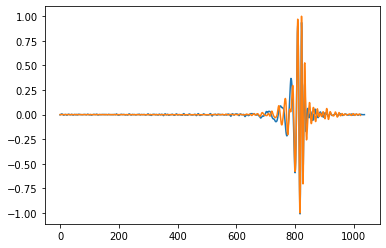

In [280]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[3364:4388][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [281]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3364:4388]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3364:4388]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [282]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190602_175927_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


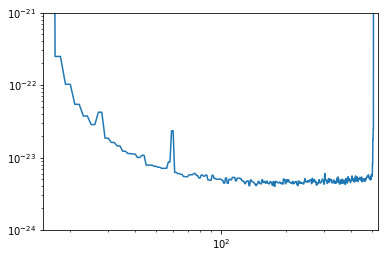

In [283]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [96]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190602_175927_reconstruction_CI_dilated_CNN_25_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


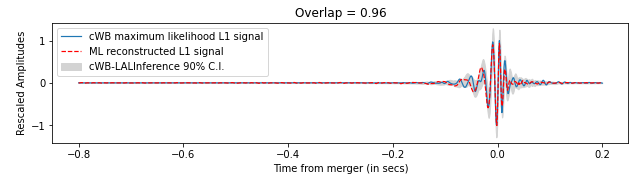

In [98]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


In [286]:
# Create FrequencySeries for PSD

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190602_175927_rec_signal_time_L1.dat",header=0,delimiter=" ")
cwb_reconst = input_data['amp_cwb_rec,'].values[3364:4388][None,:]

import numpy as np
from scipy.fft import fft, ifft

h_fft = fft(cwb_reconst)
template_fft = fft(cwb_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(cwb_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_cwb = np.max(snr_time)


In [287]:
np.sqrt(optimal_snr_cwb)

9.417705586912938

In [269]:
import numpy as np
from scipy.fft import fft, ifft


ml_reconst = round(cwb_reconst.max())*decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)

#ml_reconst = decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)


h_fft = fft(ml_reconst)
template_fft = fft(ml_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(ml_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_ml = np.max(snr_time)


In [288]:
np.sqrt(optimal_snr_ml)

7.370514112605738

In [289]:
np.sqrt(optimal_snr_ml)/np.sqrt(optimal_snr_cwb)

0.7826231181879348

# PE comparison

In [290]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190602_175927_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [291]:
np.where((time > 1243533585.084) & (time < 1243533585.086))[0]


array([4183, 4184])

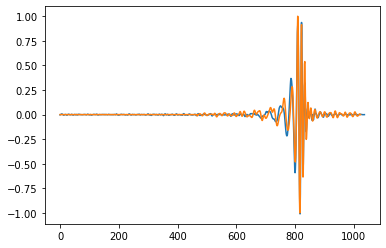

In [292]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[3364:4388][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [293]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[3364:4388]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[3364:4388]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [103]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190602_175927_reconstruction_CI_dilated_CNN_25_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


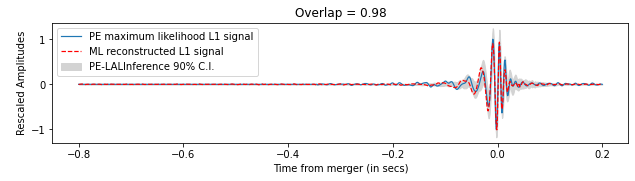

In [104]:
#plot_reconstructed(decoded_signals[0][::2][920:1024].astype(np.float64), np.squeeze(pe_reconst)[920:1024].astype(np.float64), new_upper[920:1024], new_lower[920:1024], psd)

plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


In [298]:
# Create FrequencySeries for PSD

import numpy as np
from scipy.fft import fft, ifft

with open('/fred/oz016/Chayan/samplegen_old/output/GW190602_175927_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)

h_fft = fft(amp[3364:4388][None,:])
template_fft = fft(amp[3364:4388][None,:])
psd_interpolated = np.interp(np.fft.fftfreq(len(cwb_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_pe = np.max(snr_time)


In [299]:
np.sqrt(optimal_snr_pe)

9.756842982373492

In [300]:
import numpy as np
from scipy.fft import fft, ifft


ml_reconst = round(cwb_reconst.max())*decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)

#ml_reconst = decoded_signals[0][::2][0:1024].squeeze().astype(np.float64)


h_fft = fft(ml_reconst)
template_fft = fft(ml_reconst)
psd_interpolated = np.interp(np.fft.fftfreq(len(ml_reconst)), np.fft.fftfreq(len(psd)), psd) # Interpolate PSD to match data frequency bins
snr_freq = (h_fft * template_fft.conjugate())
snr_time = np.abs(ifft(snr_freq))
optimal_snr_ml = np.max(snr_time)


In [ ]:
np.sqrt(optimal_snr_ml)

# GW190412

In [19]:
import pandas as pd

#input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190412_rec_signal_time_L1.dat",header=0,delimiter=" ")

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190412_rec_signal_time_H1.dat",header=0,delimiter=" ")


In [20]:
#np.where((input_data['time,'].values > 1239082262.200) & (input_data['time,'].values < 1239082262.202))[0]

np.where((input_data['time,'].values > 1239082262.202) & (input_data['time,'].values < 1239082262.204))[0]


array([8399, 8400])

In [21]:
#8397 -(1024*0.8)
8399 -(1024*0.8)

7579.8

In [22]:
#8397 + (1024*0.2)
8399 + (1024*0.2)

8603.8

In [23]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190412.hdf', 'r')
#strain = f1['GW190412-v3']['l1_strain'][()]
strain = f1['GW190412-v3']['h1_strain'][()]

#f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/DeepClean_tests/cleaned_data/GW190412_DeepClean.hdf', 'r')
#strain = f1['Strain'][()]


In [11]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [12]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2063, 15, 1)


In [17]:
import tensorflow_probability as tfp

#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_15_timesteps_uncertainty.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 2063, 15, 1)      4         
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 2063, 15, 64)     256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2063, 15, 32)     6176      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2063, 15, 32)     3104      
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 2063, 15, 32)      0

In [113]:
#decoded_signals = model.predict(X_test_noisy, batch_size=1)

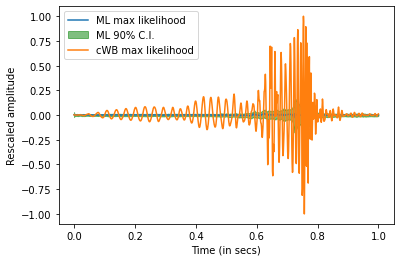

In [18]:
#plt.plot(decoded_signals[0][::2])

#cwb_reconst = input_data['amp_cwb_rec,'].values[7578:8602][None,:]
#cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

#plt.plot(cwb_reconst[0])

distribution = model(X_test_noisy)
    
# Extract mean and standard deviation from the distribution
mean_preds = distribution.mean()
std_preds = distribution.stddev()
 
mean_preds = mean_preds.numpy().squeeze()
std_preds = std_preds.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound = mean_preds - 2 * std_preds
upper_bound = mean_preds + 2 * std_preds

time = np.linspace(0.0, 1.0, 1024)

plt.plot(time, mean_preds[::2][0:1024], label ='ML max likelihood')

cwb_reconst = input_data['amp_cwb_rec,'].values[7580:8604][0:1024][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.fill_between(time, lower_bound[::2][0:1024], upper_bound[::2][0:1024], color='green', alpha=0.5, label='ML 90% C.I.')
plt.plot(time, cwb_reconst[0], label ='cWB max likelihood')
plt.xlabel('Time (in secs)')
plt.ylabel('Rescaled amplitude')
plt.legend()

#plt.savefig('IMBH_test/O3_real_events/GW190521_uncertainty.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


In [24]:
#new_lower = []
#for value in input_data['amp_post_lower_90_cr,'].values[7578:8602]:
#    if value > 0.0:
#        value = value/maximum
#    elif value < 0.0:
#        value = value/minimum
#    new_lower.append(value)
        
#new_upper = []
#for value in input_data['amp_post_upper_90_cr'].values[7578:8602]:
#    if value > 0.0:
#        value = value/maximum
#    elif value < 0.0:
#        value = value/minimum
#    new_upper.append(value)
    

new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7580:8604]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7580:8604]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
        

In [25]:
#with open('/fred/oz016/Chayan/samplegen_old/output/GW190412_L1_psd.dat', 'r') as file:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190412_H1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


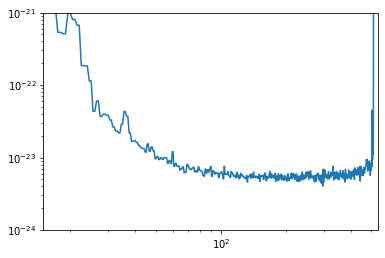

In [26]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [118]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190412_reconstruction_CI_dilated_CNN_25_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


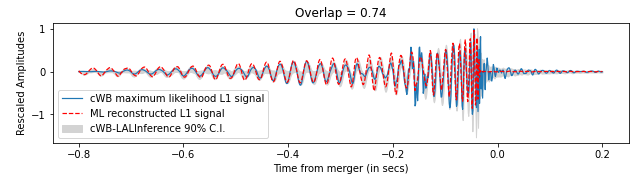

In [119]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


In [43]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, lower_bound, upper_bound, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB reconstruction')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstruction', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-90% C.I.')
    signal_axes.fill_between(time,lower_bound,upper_bound, color='lightpink', label='ML 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend(loc='upper left', fontsize=9)
    
    plt.savefig('IMBH_test/O3_real_events/GW190412_reconstruction_H1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


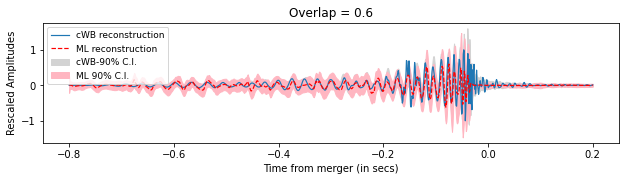

In [44]:
plot_reconstructed(mean_preds[::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, lower_bound[::2][0:1024], upper_bound[::2][0:1024], psd)


# PE comparison

In [120]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190412_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [121]:
np.where((time > 1239082262.200) & (time < 1239082262.202))[0]


array([8397, 8398])

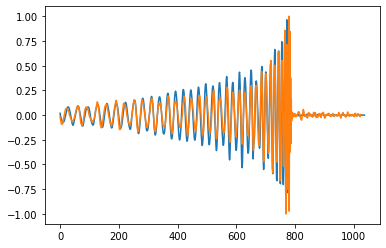

In [122]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[7578:8602][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [123]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7578:8602]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)


In [124]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190412_reconstruction_CI_dilated_CNN_25_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


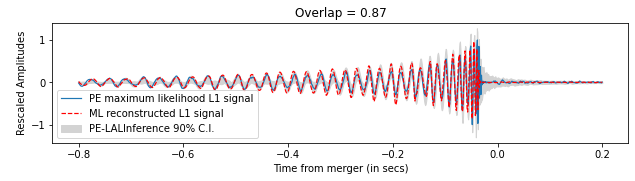

In [126]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# BayesWave comparison

In [24]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


def get_BW_reconst(reconst_BW, gps_time, event_name):

    seg_length = 8.0
    times = reconst_BW['time'].values + (gps_time - seg_length/2)

    if(event_name == 'GW190412'):
        sampling_rate = 2048.0
    else:
        sampling_rate = 1024.0

    trigger_index = np.where(times == gps_time)[0][0]
    lower_lim = int(np.round(trigger_index - (0.8*sampling_rate)))
    upper_lim = int(np.round(trigger_index + (0.2*sampling_rate)))

    BW_reconst = reconst_BW['median'].values[lower_lim:upper_lim][None,:]
    reconstructed_BW, maximum, minimum = _preprocess_data(BW_reconst,1,int(sampling_rate))

    print(len(reconstructed_BW[0]))

    new_lower = []
    for value in reconst_BW['90%_lower'].values[lower_lim:upper_lim]:
        if value > 0.0:
            value = value/maximum # check which maximum and minimum to use
        elif value < 0.0:
            value = value/minimum
        new_lower.append(value)
        
    new_upper = []
    for value in reconst_BW['90%_upper'].values[lower_lim:upper_lim]:
        if value > 0.0:
            value = value/maximum
        elif value < 0.0:
            value = value/minimum
        new_upper.append(value)  

    if(event_name == 'GW190412'):
        reconstructed_BW = reconstructed_BW[0][::2]
        new_lower = new_lower[::2]
        new_upper = new_upper[::2]

    return reconstructed_BW, new_lower, new_upper

In [ ]:
import os 

BW_file_path = os.path.join("/fred/oz016/Chayan/samplegen_old/output/GW190412_BayesWave_L1.txt")
reconst_BW = pd.read_csv(BW_file_path, header=0, delimiter=" ")

time = np.linspace(0, 1.0, 1024)

reconstructed_signal, lower_90, upper_90 = get_BW_reconst(reconst_BW, 1239082262.201, 'GW190412')     

reconstructed_signal = np.array(reconstructed_signal)

plt.plot(time, reconstructed_signal)
plt.fill_between(time, lower_90, upper_90)

2048


(1024,)

# GW190408

In [66]:
import pandas as pd

#input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190412_rec_signal_time_L1.dat",header=0,delimiter=" ")

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190408_rec_signal_time_H1.dat",header=0,delimiter=" ")


In [67]:
#np.where((input_data['time,'].values > 1239082262.200) & (input_data['time,'].values < 1239082262.202))[0]

np.where((input_data['time,'].values > 1238782700.278) & (input_data['time,'].values < 1238782700.280))[0]


array([7453, 7454])

In [68]:
7453 -(1024*0.8)

6633.8

In [69]:
7453 +(1024*0.2)

7657.8

In [70]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190408.hdf', 'r')
#strain = f1['GW190412-v3']['l1_strain'][()]
strain = f1['GW190408_181802-v1']['h1_strain'][()]


In [71]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [72]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2063, 15, 1)


In [73]:
import tensorflow_probability as tfp

#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_15_timesteps_uncertainty.h5', custom_objects={'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention, 'IndependentNormal': tfp.layers.IndependentNormal,'negloglik': negloglik})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 2063, 15, 1)      4         
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 2063, 15, 64)     256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2063, 15, 32)     6176      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2063, 15, 32)     3104      
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 2063, 15, 32)      0

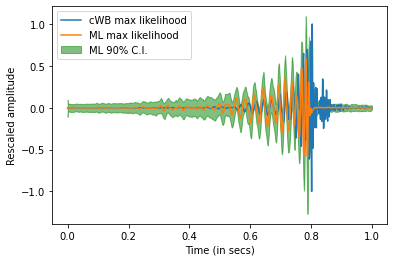

In [74]:
#plt.plot(decoded_signals[0][::2])

#cwb_reconst = input_data['amp_cwb_rec,'].values[7578:8602][None,:]
#cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

#plt.plot(cwb_reconst[0])

distribution = model(X_test_noisy)
    
# Extract mean and standard deviation from the distribution
mean_preds = distribution.mean()
std_preds = distribution.stddev()
 
mean_preds = mean_preds.numpy().squeeze()
std_preds = std_preds.numpy().squeeze()

# Calculate the upper and lower bounds of the 2-standard deviation interval
lower_bound = mean_preds - 2 * std_preds
upper_bound = mean_preds + 2 * std_preds

time = np.linspace(0.0, 1.0, 1024)

plt.plot(time, cwb_reconst[0], label ='cWB max likelihood')
plt.plot(time, mean_preds[::2][0:1024], label ='ML max likelihood')

cwb_reconst = input_data['amp_cwb_rec,'].values[6634:7658][0:1024][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.fill_between(time, lower_bound[::2][0:1024], upper_bound[::2][0:1024], color='green', alpha=0.5, label='ML 90% C.I.')

plt.xlabel('Time (in secs)')
plt.ylabel('Rescaled amplitude')
plt.legend()

#plt.savefig('IMBH_test/O3_real_events/GW190521_uncertainty.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


In [75]:
#new_lower = []
#for value in input_data['amp_post_lower_90_cr,'].values[7578:8602]:
#    if value > 0.0:
#        value = value/maximum
#    elif value < 0.0:
#        value = value/minimum
#    new_lower.append(value)
        
#new_upper = []
#for value in input_data['amp_post_upper_90_cr'].values[7578:8602]:
#    if value > 0.0:
#        value = value/maximum
#    elif value < 0.0:
#        value = value/minimum
#    new_upper.append(value)
    

new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6634:7658]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6634:7658]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
        

In [76]:
#with open('/fred/oz016/Chayan/samplegen_old/output/GW190412_L1_psd.dat', 'r') as file:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190408_H1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


In [77]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, lower_bound, upper_bound, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB reconstruction')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstruction', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-90% C.I.')
    signal_axes.fill_between(time,lower_bound,upper_bound, color='lightpink', label='ML 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend(loc='upper left', fontsize=9)
    
    plt.savefig('IMBH_test/O3_real_events/GW190408_reconstruction_H1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


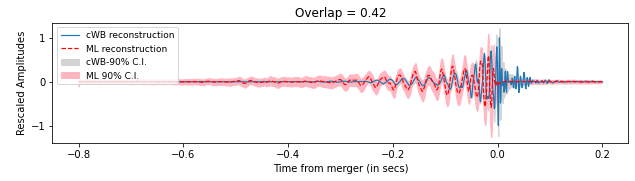

In [78]:
plot_reconstructed(mean_preds[::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, lower_bound[::2][0:1024], upper_bound[::2][0:1024], psd)


In [79]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190408_maxl_li_signal_time_H1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [80]:
np.where((time > 1238782700.278) & (time < 1238782700.280))[0]


array([7453, 7454])

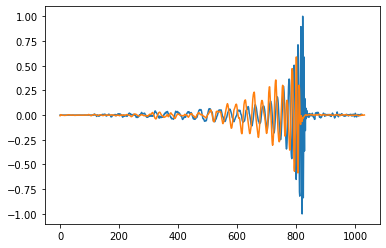

In [84]:
pe_reconst = amp[6634:7658][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])

plt.plot(mean_preds[::2])


In [82]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6634:7658]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6634:7658]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)


In [ ]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, lower_bound, upper_bound, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB reconstruction')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstruction', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-90% C.I.')
    signal_axes.fill_between(time,lower_bound,upper_bound, color='lightpink', label='ML 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend(loc='upper left', fontsize=9)
    
    plt.savefig('IMBH_test/O3_real_events/GW190408_reconstruction_H1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


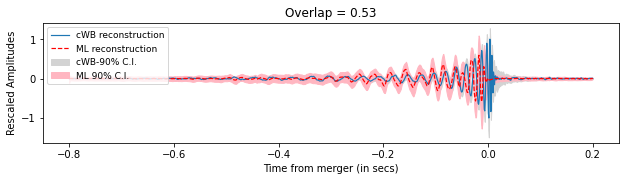

In [83]:
plot_reconstructed(mean_preds[::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], lower_bound[::2][0:1024], upper_bound[::2][0:1024], psd)


# GW190519_153544

In [6]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190519_153544_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [7]:
np.where((input_data['time,'].values > 1242315362.378) & (input_data['time,'].values < 1242315362.380))[0]


array([7556, 7557])

In [8]:
7556 -(1024*0.8)

6736.8

In [9]:
7556 + (1024*0.2)

7760.8

In [10]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190519_153544.hdf', 'r')
strain = f1['GW190519_153544-v1']['l1_strain'][()]


In [11]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [12]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [134]:
#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [135]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


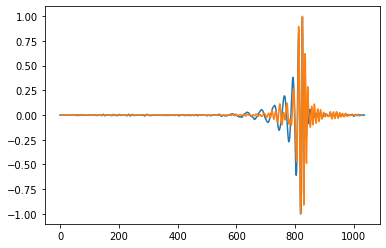

In [136]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6737:7761][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [137]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6737:7761]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6737:7761]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [138]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190519_153544_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


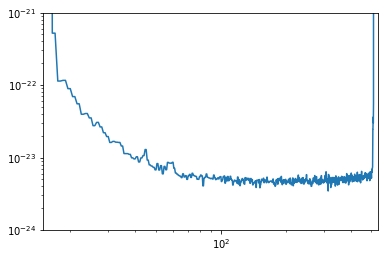

In [139]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [140]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190519_153544_reconstruction_CI_dilated_CNN_25_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


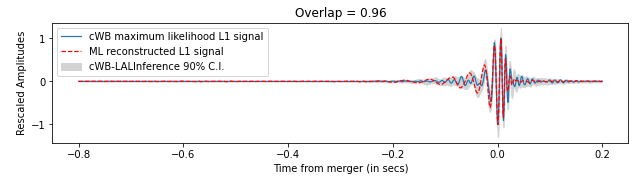

In [141]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [142]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190519_153544_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [143]:
np.where((time > 1242315362.378) & (time < 1242315362.380))[0]


array([7556, 7557])

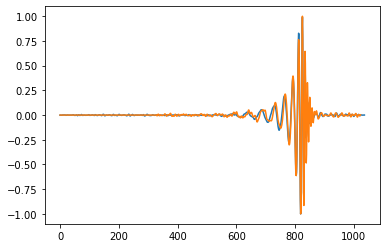

In [144]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6737:7761][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [145]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6737:7761]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6737:7761]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)


In [146]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190519_153544_reconstruction_CI_dilated_CNN_25_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


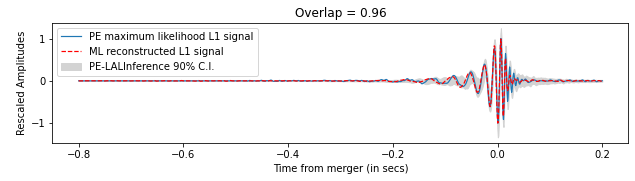

In [147]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW190517_055101

In [52]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190517_055101_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [53]:
np.where((input_data['time,'].values > 1242107479.819) & (input_data['time,'].values < 1242107479.821))[0]


array([8007, 8008])

In [54]:
8007 -(1024*0.8)

7187.8

In [55]:
8007 + (1024*0.2)

8211.8

In [56]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190517_055101.hdf', 'r')
strain = f1['GW190517_055101-v1']['l1_strain'][()]


In [57]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [58]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2073, 25, 1)


In [59]:
#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2073, 25, 128)    512       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2073, 25, 128)    49280     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 2073, 25, 128)    5

In [60]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


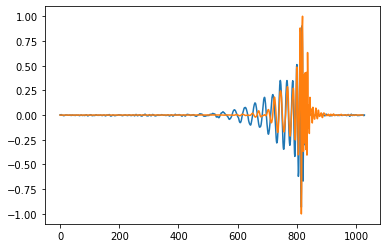

In [39]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[7188:8212][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [40]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[7188:8212]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[7188:8212]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [41]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190517_055101_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


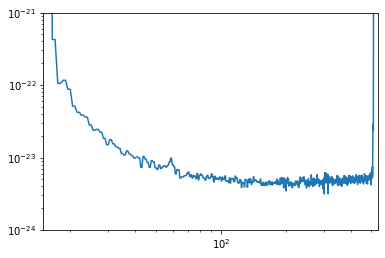

In [42]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [43]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190517_055101_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


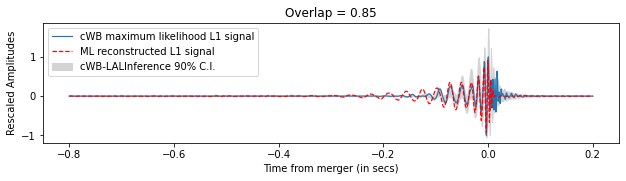

In [44]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [61]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190517_055101_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [62]:
np.where((time > 1242107479.819) & (time < 1242107479.821))[0]


array([8007, 8008])

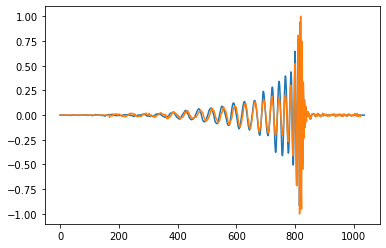

In [63]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[7188:8212][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [64]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190517_055101_reconstruction_CI_dilated_CNN_25_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


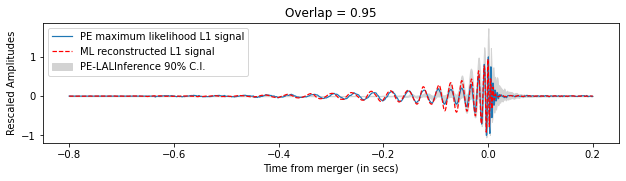

In [65]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


# GW190503_185404

In [82]:
import pandas as pd

input_data=pd.read_csv("/fred/oz016/Chayan/samplegen_old/output/GW190503_185404_rec_signal_time_L1.dat",header=0,delimiter=" ")


In [83]:
np.where((input_data['time,'].values > 1240944862.284) & (input_data['time,'].values < 1240944862.286))[0]


array([7459, 7460])

In [84]:
7459 -(1024*0.8)

6639.8

In [85]:
7459 + (1024*0.2)

7663.8

In [86]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190503_185404.hdf', 'r')
strain = f1['GW190503_185404-v1']['l1_strain'][()]


In [87]:
strain = strain[None,:]
strain, maximum, minimum = _preprocess_data(strain, 1, 2048)
strain = np.array(strain)


In [88]:
X_test_noisy = reshape_sequences(1, strain)

# Reshape arrays to fit into Keras model
X_test_noisy = X_test_noisy[:,:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)

X_test_noisy = X_test_noisy.astype("float32")


x_test_noisy shape: (1, 2058, 10, 1)


In [89]:
#from keras.models import load_model

model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})
 
# load model
#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2058, 10, 32)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2058, 10, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2058, 5, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2058, 5, 16)      1552      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2058, 5, 16)      0

In [90]:
decoded_signals = model.predict(X_test_noisy, batch_size=1)


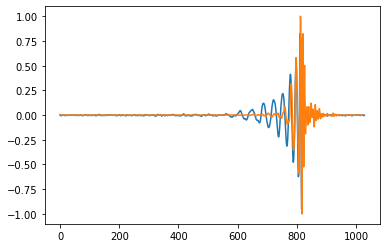

In [91]:
plt.plot(decoded_signals[0][::2])

cwb_reconst = input_data['amp_cwb_rec,'].values[6640:7664][None,:]
cwb_reconst, maximum, minimum = _preprocess_data(cwb_reconst,1,1024)

plt.plot(cwb_reconst[0])


In [92]:
new_lower = []
for value in input_data['amp_post_lower_90_cr,'].values[6640:7664]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_lower.append(value)
        
new_upper = []
for value in input_data['amp_post_upper_90_cr'].values[6640:7664]:
    if value > 0.0:
        value = value/maximum
    elif value < 0.0:
        value = value/minimum
    new_upper.append(value)
    

In [93]:
with open('/fred/oz016/Chayan/samplegen_old/output/GW190503_185404_L1_psd.dat', 'r') as file:
    freq = []
    psd = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            freq.append(col1)
            psd.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")
            
    freq = np.array(freq)
    psd = np.array(psd)


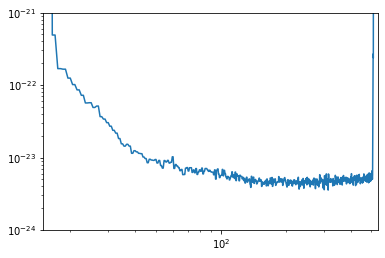

In [94]:
plt.plot(freq, np.sqrt(psd))
plt.xlim(15,)
plt.ylim(1e-24, 1e-21)
plt.xscale('log')
plt.yscale('log')


In [95]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='cWB maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='cWB-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190503_185404_reconstruction_CI_dilated_CNN_10_timesteps_L1_cWB_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


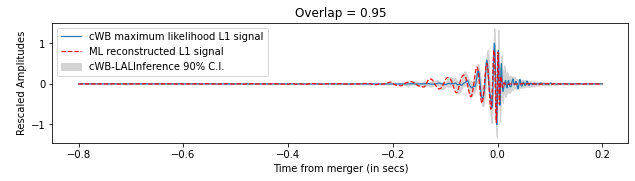

In [96]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype('float64'), np.squeeze(cwb_reconst).astype('float64'), new_upper, new_lower, psd)


# PE comparison

In [102]:
# Replace 'filename.dat' with your file path
with open('/fred/oz016/Chayan/samplegen_old/output/GW190503_185404_maxl_li_signal_time_L1.dat', 'r') as file:
    time = []
    amp = []
    for line in file:
        # Split the line into parts based on whitespace or specific delimiter
        parts = line.split()  # Use split('\t') for tab-delimited files
        
        try:
            col1 = float(parts[0])
            col2 = float(parts[1])
            time.append(col1)
            amp.append(col2)
        except ValueError:
            print(f"Warning: Can't convert line to floats: {line.strip()}")

time = np.array(time)
amp = np.array(amp)


In [103]:
np.where((time > 1240944862.284) & (time < 1240944862.286))[0]


array([7459, 7460])

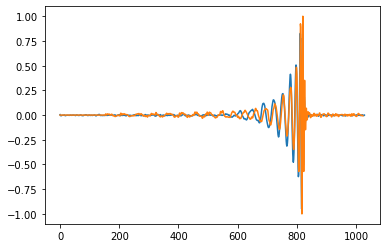

In [104]:
plt.plot(decoded_signals[0][::2])

pe_reconst = amp[6640:7664][None,:]
pe_reconst, maximum, minimum = _preprocess_data(pe_reconst,1,1024)

plt.plot(pe_reconst[0])


In [105]:
from pycbc.filter import match, overlap
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, upper_90, lower_90, psd):
    
#    time_buffer = 104.0/1024
    time_buffer = 1
    length_signal = len(decoded_signals)

    fig = plt.figure(figsize=(10,5))
    
    time = np.linspace(-0.80, 0.20, length_signal)

#    time = np.linspace(-0.80, 0.20, 1024)[920:1024]
    
    
    f_low = 20
    sample_rate = 1024

    # Length of corresponding time series and frequency series
    tlen = int(sample_rate * time_buffer)
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/1024)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/1024)
    psd = FrequencySeries(psd, delta_f=delta_f)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)
    psd.resize(flen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_title('Overlap = {m}'.format(m=np.round(m,2)))
    signal_axes.plot(time,pure_signals, linewidth=1.2, label ='PE maximum likelihood L1 signal')
    signal_axes.plot(time,decoded_signals, linewidth=1.2, label ='ML reconstructed L1 signal', c='red', linestyle='dashed')
    signal_axes.fill_between(time,lower_90,upper_90, color='lightgrey', label='PE-LALInference 90% C.I.')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.set_xlabel('Time from merger (in secs)')
    signal_axes.legend()
    
    plt.savefig('IMBH_test/O3_real_events/GW190503_185404_reconstruction_CI_dilated_CNN_10_timesteps_L1_PE_comparison.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


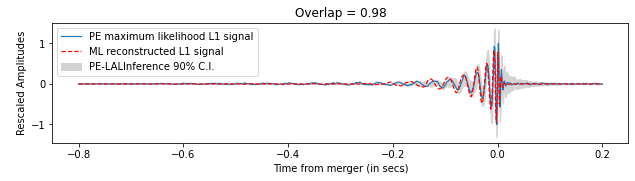

In [106]:
plot_reconstructed(decoded_signals[0][::2][0:1024].astype(np.float64), np.squeeze(pe_reconst)[0:1024].astype(np.float64), new_upper[0:1024], new_lower[0:1024], psd)


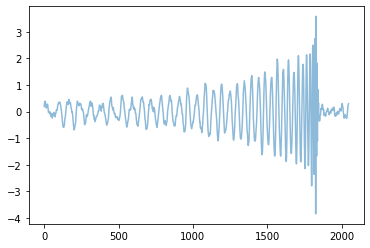

In [11]:
plt.plot(signal_1, alpha=0.5)


In [10]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/default_IMBH_test_IMRPhenomXPHM_signal_noise_SNR-20to40_mchirp_all_test_1.hdf', 'r')

signal_1 = f1['injection_parameters']['l1_signal_whitened'][0]


In [131]:
import numpy as np
from pycbc.filter import sigma
from pycbc.types import TimeSeries, FrequencySeries

# Create TimeSeries for reconstructed signals

ml_reconst_ts = TimeSeries(signal.astype(np.float64), delta_t=1.0/1024)

# Convert TimeSeries to FrequencySeries
ml_reconst_fs = ml_reconst_ts.to_frequencyseries()


# Optionally, calculate SNR if needed
sigma(htilde=ml_reconst_ts, psd=None, low_frequency_cutoff=20.0)


6395.35585196412

In [128]:
f1['injection_parameters']['l1_snr'][10]*f1['injection_parameters']['scale_factor'][10]

13.184120095932979

In [120]:
f1['injection_parameters']['l1_snr'][0]*f1['injection_parameters']['scale_factor'][0]/sigma(htilde=ml_reconst_ts, psd=None, low_frequency_cutoff=20.0)


98.71193398168333

In [121]:
strain = f1['injection_samples']['l1_strain'][0]


In [122]:
strain_time_series=TimeSeries(strain,delta_t=1.0/2048.0, epoch=0,dtype=None, copy=True)
strain_freq_series=strain_time_series.to_frequencyseries(delta_f=1.0/1)
template_time_series = TimeSeries(signal,
                delta_t=1.0/2048.0,
                dtype=None, copy=True)


In [123]:
from pycbc.filter import matched_filter

template_freq_series_hp=template_time_series.to_frequencyseries(
                delta_f=strain_freq_series.delta_f)

# Resize template to work with the sample
template_freq_series_hp.resize(len(strain_freq_series))

# Time shift the template so that the SNR peak matches the merger time
template_freq_series_hp = template_freq_series_hp.cyclic_time_shift(template_freq_series_hp.start_time)

# Compute SNR time-series from optimal matched filtering template
snr_series = matched_filter(template_freq_series_hp,
                                        strain_freq_series.astype(complex),
                                        psd=None, low_frequency_cutoff=20)


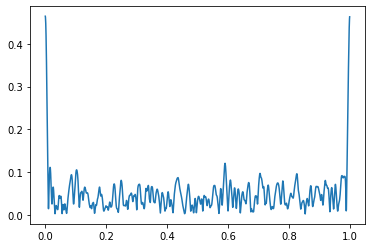

In [124]:
plt.plot(snr_series.sample_times, abs(snr_series))
